In [1]:
import numpy as np
import pandas as pd
#import plotly.express as px
#from plotly.subplots import make_subplots
#import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#import mplcyberpunk
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, precision_recall_curve, f1_score,accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
sns.set(style="white", palette="muted", color_codes=True)
pd.set_option("display.width", 1000)


In [2]:
bs_df = pd.read_csv("C:/Users/emirh/Downloads/full_data.csv")

In [3]:
bs_df.columns = bs_df.columns.str.lower()
discrete_cols = [var for var in bs_df.columns if bs_df[var].dtypes!="O" and bs_df[var].nunique()<10]
continuous_cols = [var for var in bs_df.columns if bs_df[var].dtypes!="O" and var!="stroke" and var not in discrete_cols ]
cat_cols = [var for var in bs_df.columns if bs_df[var].dtypes=="O"]
#numerical_cols = [var for var in bs_df.columns if bs_df[var].dtypes != "O" and var != "stroke"]
mixed_cols = discrete_cols + cat_cols
    

In [4]:
class DataOperation:
    
    def __init__(self,df):
        self.df=df
        
    def data_preview(self):

        print(self.df.head())
        print("*"*40)
        print(f"Shape of data: {self.df.shape}")
        print("*"*40)
        print(self.df.info())
        print("*"*40)
        print(self.df.describe().T)

    def data_summary(self):
        global discrete_cols,continuous_cols,cat_cols,mixed_cols
        
        cardinality = self.df[cat_cols].nunique()

        print(f"Total Discrete Variables: {len(discrete_cols)} --> {discrete_cols}")
        print(f"Total Continuous Variables: {len(continuous_cols)} --> {continuous_cols}")
        print(f"Total Categorical Variables: {len(cat_cols)} --> {cat_cols}")
        print("*"*40)
        print(f"Cardinality: \n{cardinality}")
        for col in self.df[mixed_cols]:
            print("*"*40)
            print(f"Counts of unique values for variables:\n\033[1m {col} \033[0m \n{self.df[col].value_counts()}")

    def missing_values_analysis(self):
        
        if self.df.isnull().sum().any():
            missing_percent = self.df.isnull().sum()/len(self.df)*100
            missing_total = self.df.isnull().sum()
            missing_table = pd.concat([missing_total,missing_percent],axis=1)
            missing_table.rename(columns={0:"Missing Value",1:"% of Total Value"},inplace=True)
            missing_table.sort_values(by="% of Total Value",ascending=False).round(1)
        else:
            print("There is no missing value.")

    def numerical_viz(self):
        global continuous_cols

        for col in self.df[continuous_cols]:
            
            fig, ax = plt.subplots(1, 2, sharex=True,figsize=(10, 4))
            sns.set_color_codes(palette="pastel")
            sns.histplot(x=self.df[col],ax=ax[0],kde=True).set(title=f"Distribution of {col}")
            sns.boxplot(x=self.df[col],ax=ax[1]).set(title=f"Box-plot of {col}")
            sns.despine(left=True)
            plt.show() 
              
    def categorical_viz(self):
        global mixed_cols
        c=1
        fig = plt.figure(figsize=(15,10))
        for col in self.df[mixed_cols]:

            plt.subplot(2,4,c)
            sns.countplot(x=self.df[col]).set(title=f"Plot of {col}")
            plt.xticks(rotation=30)
            sns.despine()
            c = c+1
        plt.tight_layout()    
        plt.show()

    def skewness_kurtosis(self):
        global continuous_cols
        skew={}
        kurt={}
        for col in self.df[continuous_cols]:
            skewness = self.df[col].skew(axis=0).round(2)
            kurtosis = self.df[col].kurtosis(axis=0).round(2)
            skew[col]=skewness
            kurt[col]=kurtosis
        skw_kurt=pd.DataFrame({"skew":skew,"kurtosis":kurt}).T
        print(skw_kurt) 
        for col in skw_kurt.columns:
            if ((skw_kurt[col].iloc[0] > 1.5) | (skw_kurt[col].iloc[0] < -1.5)) and ((skw_kurt[col].iloc[1] > 1.5) | (skw_kurt[col].iloc[1] <-1.5)):
                print("*"*30)
                print(f"\033[1mSkewness and kurtosis were detected.\033[0m\nVariable: {col}\n\033[1mWe'll apply Box-Cox transformation.\033[0m")
                self.df[col +"_boxcox"], df_lambda = stats.boxcox(self.df[col])
                self.df.drop([col], axis=1,inplace=True)
                continuous_cols.remove(col)
                continuous_cols += [col +"_boxcox"]
                self.numerical_viz()
    def one_hot_encoder(self):
        
        self.df["gender"] = [1 if i == "Male" else 0 for i in self.df["gender"]]
        self.df["ever_married"] = [ 1 if i =="Yes" else 0 for i in self.df["ever_married"] ]
        self.df["residence_type"] = [ 1 if i =="Urban" else 0 for i in self.df["residence_type"] ]
        self.df = pd.get_dummies(self.df,columns=["work_type", "smoking_status"], drop_first=True)
        return self.df.head()

    def get_train_test_data(self,imbalance=True):
        X = self.df.drop(["stroke"],axis=1)
        y = self.df["stroke"]
        X_cols = X.columns
        print(y.value_counts())

        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
        if imbalance:
            
            smt = SMOTE(random_state = 42)
            X_smt,y_smt = smt.fit_resample(X,y)
            X_train,X_test,y_train,y_test = train_test_split(X_smt,y_smt,test_size=0.2,random_state=42)

            print(f"Before Oversampling, y_train: \n{y.value_counts()}")
            print(f"After Oversampling, y_train_smt: \n{y_smt.value_counts()}")

            return X_train,X_test,y_train,y_test,X_cols
        else:
            X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

            return X_train,X_test,y_train,y_test,X_cols


In [5]:
bs_op = DataOperation(bs_df)

In [6]:
bs_op.data_preview()

   gender   age  hypertension  heart_disease ever_married      work_type residence_type  avg_glucose_level   bmi   smoking_status  stroke
0    Male  67.0             0              1          Yes        Private          Urban             228.69  36.6  formerly smoked       1
1    Male  80.0             0              1          Yes        Private          Rural             105.92  32.5     never smoked       1
2  Female  49.0             0              0          Yes        Private          Urban             171.23  34.4           smokes       1
3  Female  79.0             1              0          Yes  Self-employed          Rural             174.12  24.0     never smoked       1
4    Male  81.0             0              0          Yes        Private          Urban             186.21  29.0  formerly smoked       1
****************************************
Shape of data: (4981, 11)
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 

In [7]:
bs_op.data_summary()

Total Discrete Variables: 3 --> ['hypertension', 'heart_disease', 'stroke']
Total Continuous Variables: 3 --> ['age', 'avg_glucose_level', 'bmi']
Total Categorical Variables: 5 --> ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
****************************************
Cardinality: 
gender            2
ever_married      2
work_type         4
residence_type    2
smoking_status    4
dtype: int64
****************************************
Counts of unique values for variables:
 hypertension  
0    4502
1     479
Name: hypertension, dtype: int64
****************************************
Counts of unique values for variables:
 heart_disease  
0    4706
1     275
Name: heart_disease, dtype: int64
****************************************
Counts of unique values for variables:
 stroke  
0    4733
1     248
Name: stroke, dtype: int64
****************************************
Counts of unique values for variables:
 gender  
Female    2907
Male      2074
Name: gender, dtyp

In [8]:
bs_op.missing_values_analysis()

There is no missing value.


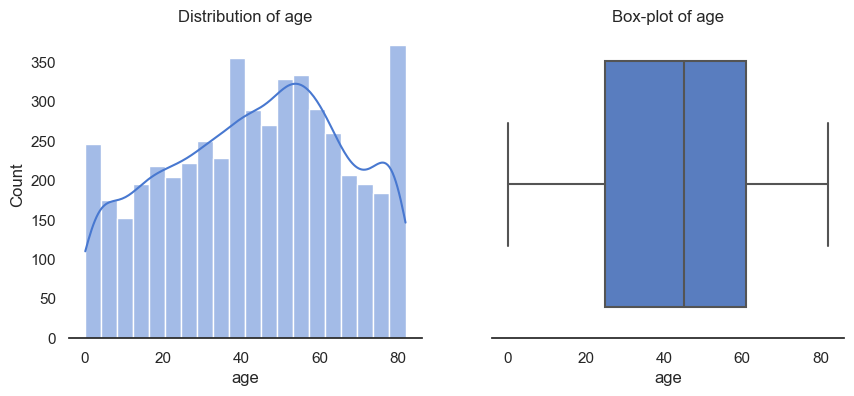

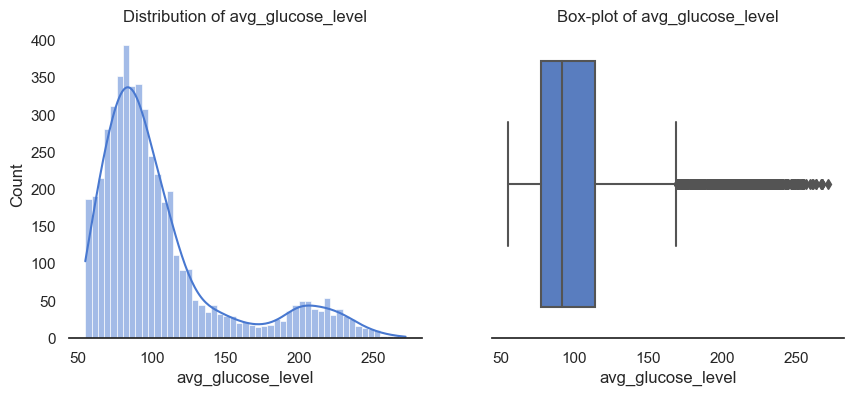

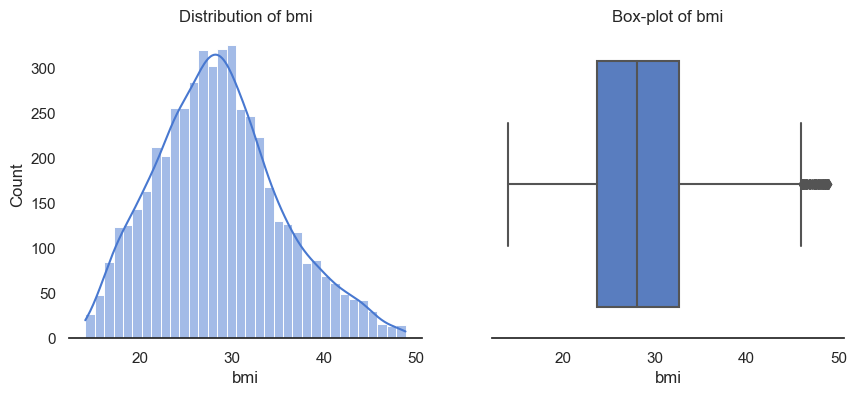

In [9]:
bs_op.numerical_viz()

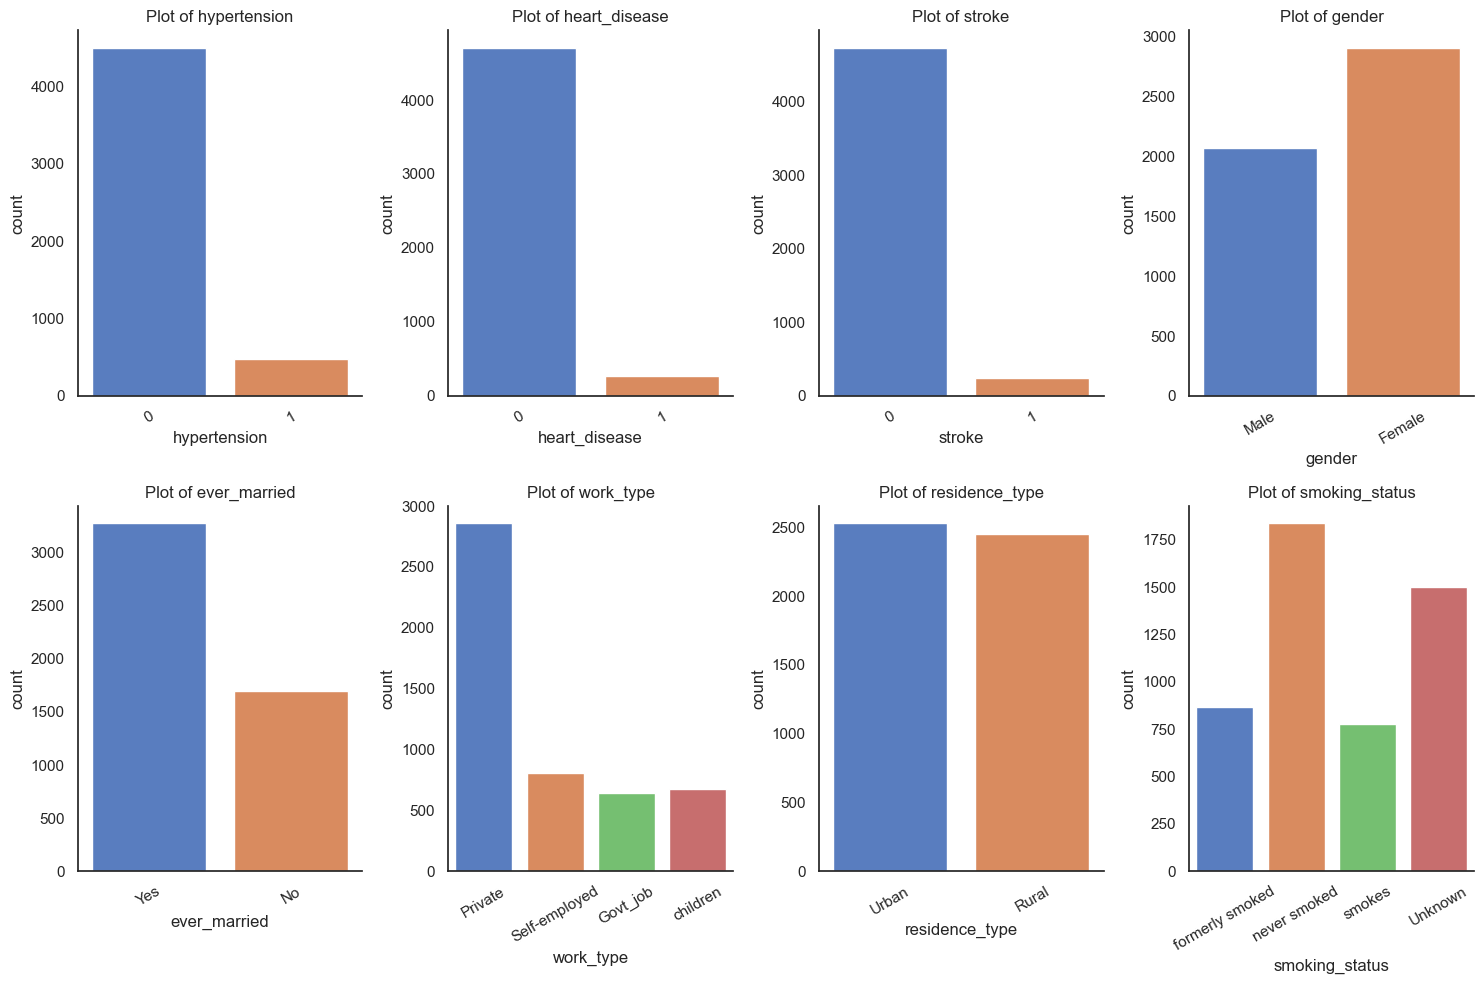

In [10]:
bs_op.categorical_viz()

           age  avg_glucose_level   bmi
skew     -0.14               1.59  0.37
kurtosis -0.99               1.75 -0.14
******************************
Skewness and kurtosis were detected.
Variable: avg_glucose_level
We'll apply Box-Cox transformation.


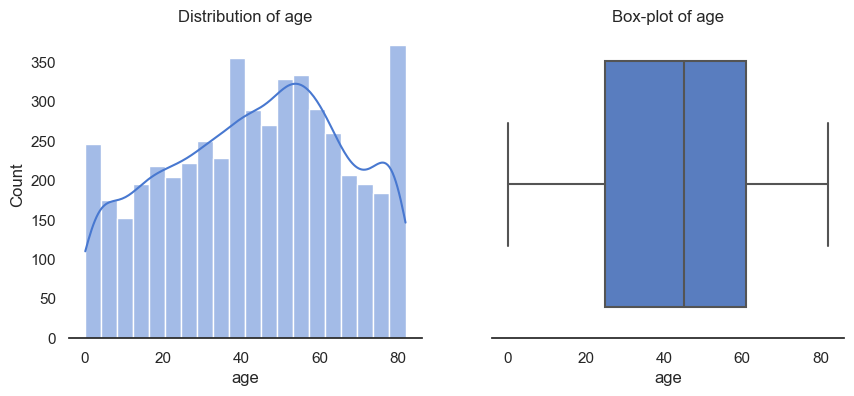

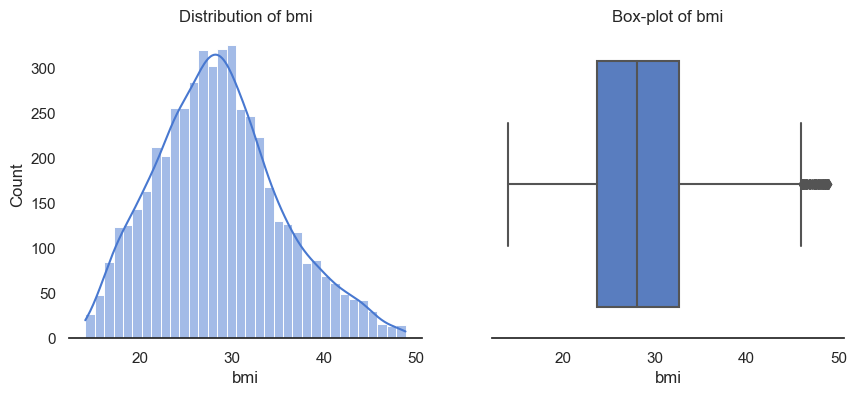

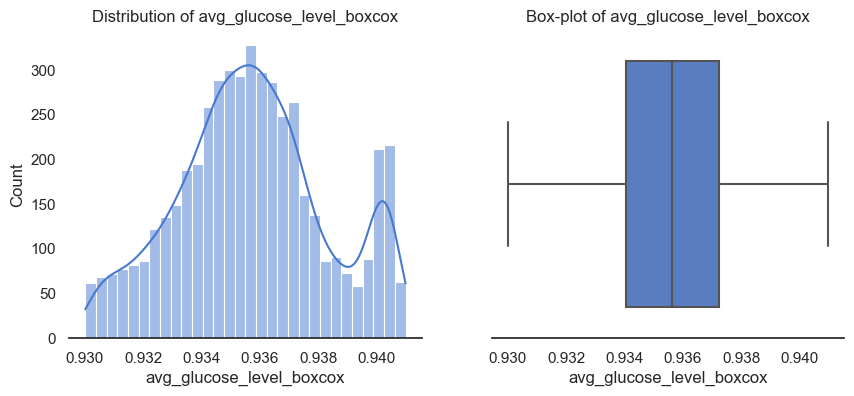

In [11]:
bs_op.skewness_kurtosis()

In [12]:
bs_op.one_hot_encoder()

,gender,age,hypertension,heart_disease,ever_married,residence_type,bmi,stroke,avg_glucose_level_boxcox,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,36.6,1,0.940492,1,0,0,1,0,0
1,1,80.0,0,1,1,0,32.5,1,0.936735,1,0,0,0,1,0
2,0,49.0,0,0,1,1,34.4,1,0.939423,1,0,0,0,0,1
3,0,79.0,1,0,1,0,24.0,1,0.939494,0,1,0,0,1,0
4,1,81.0,0,0,1,1,29.0,1,0.939767,1,0,0,1,0,0


In [13]:
train_test=bs_op.get_train_test_data()

0    4733
1     248
Name: stroke, dtype: int64
Before Oversampling, y_train: 
0    4733
1     248
Name: stroke, dtype: int64
After Oversampling, y_train_smt: 
1    4733
0    4733
Name: stroke, dtype: int64


### Model Building

In [14]:
class modelBuilding():

    def __init__(self):

        pass

    def gb_models(self):
        
        models = {"Xgboost":XGBClassifier(random_state=42),
                    "LightGBM":LGBMClassifier(random_state=42),
                    "CatBoost":CatBoostClassifier(random_state=42)}
        params = [{"n_estimators":[20,50,100,200,500],
                    "max_depth": [2,4,6,8],
                    "learning_rate":[0.001,0.01,0.02,0.04,0.1,0.2,0.3,0.5]}]
                
        return models,params
    
    def fine_tuning(self):
        global train_test
        X_train,X_test,y_train,y_test,X_cols = train_test
        models,params = self.gb_models()
        best_param={}
    
        for name,model in models.items():
            grid_search = GridSearchCV(model,params,cv=5,scoring="accuracy",return_train_score=True,n_jobs=-1)
            grid_search.fit(X_train,y_train)
            print(f"{name}: \nThe best score: {grid_search.best_score_} \nThe best param: {grid_search.best_params_}")
            best_param[name]=grid_search.best_params_
        return best_param    
        
    def model_evaluation(self,model_name,n_jobs=-1):
        global best_param
        X_train,X_test,y_train,y_test,X_cols = train_test
        
        
        if model_name == "Xgboost":
            print("-----------\033[1mXGBOOST\033[0m-----------")
            clf = XGBClassifier(n_estimators=best_param["Xgboost"]["n_estimators"],max_depth=best_param["Xgboost"]["max_depth"],learning_rate=best_param["Xgboost"]["learning_rate"],n_jobs=n_jobs)
            clf.fit(X_train,y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            print(f"Train Data Accuracy Score: {accuracy_score(y_train,y_pred_train)}")
            print(f"Test Data Accuracy Score: {accuracy_score(y_test,y_pred_test)}")
            print("-"*30)
            print(f"Classification Report: \n\n{classification_report(y_test,y_pred_test)}")
            xgb_sorted_idx = clf.feature_importances_.argsort()
            plt.barh(X_cols[xgb_sorted_idx], clf.feature_importances_[xgb_sorted_idx])
            plt.title("Xgboost Feature Importance")
        elif model_name == "LightGBM":
            print("-----------\033[1mLightGBM\033[0m-----------")
            clf = LGBMClassifier(n_estimators=best_param["LightGBM"]["n_estimators"],max_depth=best_param["LightGBM"]["max_depth"],learning_rate=best_param["LightGBM"]["learning_rate"],n_jobs=n_jobs)
            clf.fit(X_train,y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            print("-----------\033[1mChecking Overfitting\033[0m-----------")
            print(f"Train Data Accuracy Score: {accuracy_score(y_train,y_pred_train)}")
            print(f"Test Data Accuracy Score: {accuracy_score(y_test,y_pred_test)}")
            print("-"*30)
            print(f"Classification Report: \n\n{classification_report(y_test,y_pred_test)}")
            lgbm_sorted_idx = clf.feature_importances_.argsort()
            plt.barh(X_cols[lgbm_sorted_idx], clf.feature_importances_[lgbm_sorted_idx])
            plt.title("LightGBM Feature Importance")
        elif model_name == "CatBoost":
            print("-----------\033[1mCatBoost\033[0m-----------")
            clf = LGBMClassifier(n_estimators=best_param["CatBoost"]["n_estimators"],max_depth=best_param["CatBoost"]["max_depth"],learning_rate=best_param["CatBoost"]["learning_rate"],n_jobs=n_jobs)
            clf.fit(X_train,y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            print("-----------\033[1mChecking Overfitting\033[0m-----------")
            print(f"Train Data Accuracy Score: {accuracy_score(y_train,y_pred_train)}")
            print(f"Test Data Accuracy Score: {accuracy_score(y_test,y_pred_test)}")
            print("-"*30)
            print(f"Classification Report: \n\n{classification_report(y_test,y_pred_test)}")
            cat_sorted_idx = clf.feature_importances_.argsort()
            plt.barh(X_cols[cat_sorted_idx], clf.feature_importances_[cat_sorted_idx])
            plt.title("Catboost Feature Importance")   
        else:
            raise ValueError(f"Invalid Model \nPlease enter only one of the following model names: \nXgboost \nLightGBM \nCatboost")

In [15]:
clf=modelBuilding()

In [16]:
clf.gb_models()

({'Xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=42, ...),
  'LightGBM': LGBMClassifier(random_state=42),
  'CatBoost': <catboost.core.CatBoostClassifier at 0x27302a8c610>},
 [{'n_estimators': [20, 50, 100, 200, 500],
   'max_depth': [2, 4, 6, 8],
   'learning_rate': [0.001,

In [17]:
best_param=clf.fine_tuning()

Xgboost: 
The best score: 0.9494203713634244 
The best param: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 500}
LightGBM: 
The best score: 0.9543059933470228 
The best param: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 500}
0:	learn: 0.5762516	total: 152ms	remaining: 1m 15s
1:	learn: 0.4889755	total: 168ms	remaining: 41.8s
2:	learn: 0.4433068	total: 182ms	remaining: 30.1s
3:	learn: 0.4111973	total: 192ms	remaining: 23.9s
4:	learn: 0.3826604	total: 200ms	remaining: 19.8s
5:	learn: 0.3610731	total: 207ms	remaining: 17.1s
6:	learn: 0.3475206	total: 213ms	remaining: 15s
7:	learn: 0.3365456	total: 217ms	remaining: 13.4s
8:	learn: 0.3272871	total: 224ms	remaining: 12.2s
9:	learn: 0.3193877	total: 229ms	remaining: 11.2s
10:	learn: 0.3144788	total: 236ms	remaining: 10.5s
11:	learn: 0.3057369	total: 242ms	remaining: 9.82s
12:	learn: 0.2983524	total: 246ms	remaining: 9.23s
13:	learn: 0.2899965	total: 254ms	remaining: 8.81s
14:	learn: 0.2855437	total: 259ms	remaining: 8.36s
1

-----------XGBOOST-----------
Train Data Accuracy Score: 1.0
Test Data Accuracy Score: 0.9519535374868004
------------------------------
Classification Report: 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       946
           1       0.95      0.95      0.95       948

    accuracy                           0.95      1894
   macro avg       0.95      0.95      0.95      1894
weighted avg       0.95      0.95      0.95      1894



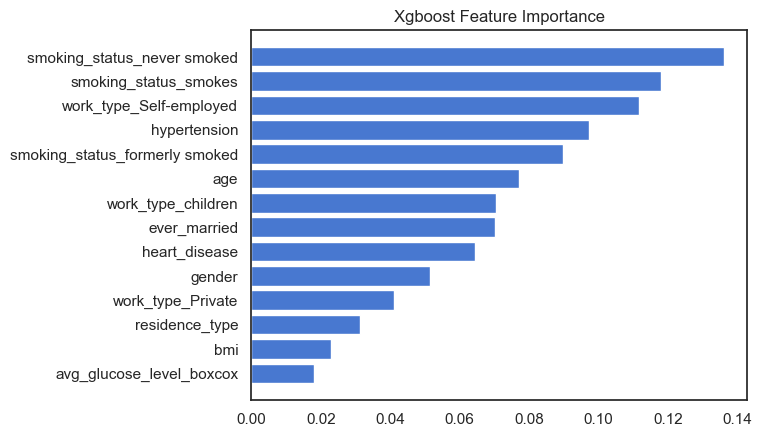

In [20]:
clf.model_evaluation("Xgboost")

-----------LightGBM-----------
-----------Checking Overfitting-----------
Train Data Accuracy Score: 1.0
Test Data Accuracy Score: 0.9588173178458289
------------------------------
Classification Report: 

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       946
           1       0.96      0.95      0.96       948

    accuracy                           0.96      1894
   macro avg       0.96      0.96      0.96      1894
weighted avg       0.96      0.96      0.96      1894



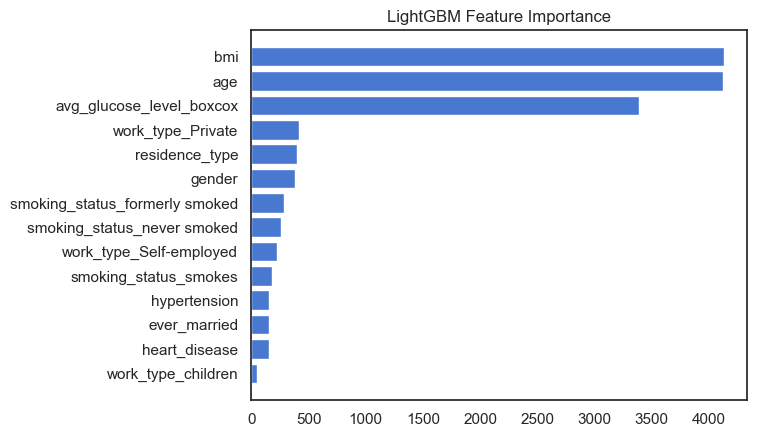

In [19]:
clf.model_evaluation("LightGBM")

-----------CatBoost-----------
-----------Checking Overfitting-----------
Train Data Accuracy Score: 1.0
Test Data Accuracy Score: 0.957233368532207
------------------------------
Classification Report: 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       946
           1       0.96      0.96      0.96       948

    accuracy                           0.96      1894
   macro avg       0.96      0.96      0.96      1894
weighted avg       0.96      0.96      0.96      1894



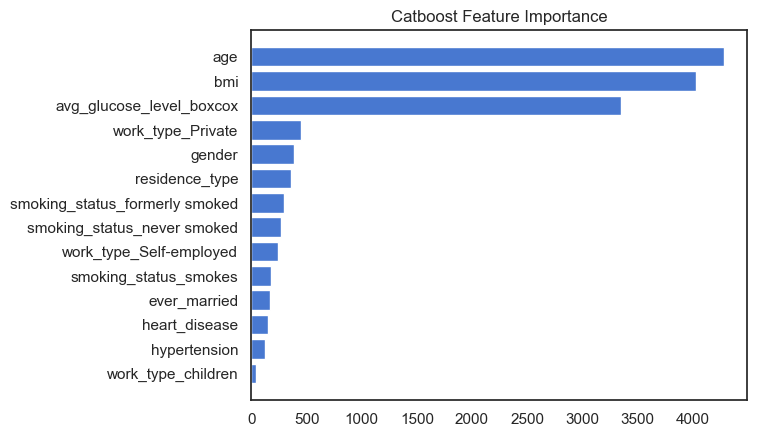

In [21]:
clf.model_evaluation("CatBoost")

### EDA